In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
def week_id_valid(week):
    if week=="w1":    return 1
    elif week=="w2":    return 2
    elif week=="w3": return 3
    else: return 4

In [116]:
def visualize_forecast(y_true, y_pred):
    plt.plot(range(len(y_true)), y_true, label="Actual Forecast")
    plt.plot(range(len(y_pred)), y_pred, label = "Predicted Forecast")
    plt.title("Actual vs Predicted Forecasts")
    plt.legend()
    plt.show()

In [4]:
def mape(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))
    return mape

In [5]:
def calculate_buffer(y_true, y_pred):
    uf_y_true, uf_y_pred = [], []
    for i in range(len(y_true)):
        if y_true[i] > y_pred[i]:
            uf_y_true.append(y_true)
            uf_y_pred.append(y_pred)
    uf_y_true, uf_y_pred = np.array(uf_y_true), np.array(uf_y_pred)
    error = np.abs(uf_y_pred - uf_y_true)
    buffer = np.mean(error) + (2 * np.std(error))
    
    return buffer

In [6]:
def calculate_underforecast_mape(y_true, y_pred):
    print(len(y_true))
    uf_y_true, uf_y_pred = [], []
    for i in range(len(y_true)):
        if y_true[i] > y_pred[i]:
            uf_y_true.append(y_true)
            uf_y_pred.append(y_pred)
    print(len(uf_y_true))
#     output_errors = np.average(mape, axis=0)
            
    #uf_mape = mean_absolute_percentage_error(uf_y_true, uf_y_pred)
    return mape(uf_y_true, uf_y_pred)

In [7]:
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error
def calculate_results(y_true, y_pred):
    visualize_forecast(y_true, y_pred)
    return {'mae':mean_absolute_error(y_true, y_pred),
            'mape': mape(y_true, y_pred),
            'uf_mape': calculate_underforecast_mape(y_true, y_pred),
            'buffer': calculate_buffer(y_true, y_pred)}

In [65]:
train_data = pd.read_csv(r"./data/train_data_modified_ml_2.csv")
train_data

,CategoryCode,ItemCode,Week,WeekID,DiscountValue,DiscountedPrice,SellingPrice,OnPromotion,WeeklySales
0,category_1,3418,w1,1,NaN,NaN,NaN,0,45
1,category_1,3418,w2,2,NaN,NaN,NaN,0,50
2,category_1,3418,w3,3,NaN,NaN,NaN,0,49
3,category_1,3418,w4,4,NaN,NaN,NaN,0,38
4,category_1,3418,w1,5,NaN,NaN,NaN,0,53
...,...,...,...,...,...,...,...,...,...
3935,category_2,1105027,w4,16,NaN,NaN,NaN,0,7
3936,category_2,1105027,w1,17,NaN,NaN,NaN,0,6
3937,category_2,1105027,w2,18,NaN,NaN,NaN,0,7
3938,category_2,1105027,w3,19,NaN,NaN,NaN,0,10


In [66]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3940 entries, 0 to 3939
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CategoryCode     3940 non-null   object 
 1   ItemCode         3940 non-null   int64  
 2   Week             3940 non-null   object 
 3   WeekID           3940 non-null   int64  
 4   DiscountValue    268 non-null    float64
 5   DiscountedPrice  268 non-null    float64
 6   SellingPrice     268 non-null    float64
 7   OnPromotion      3940 non-null   int64  
 8   WeeklySales      3940 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 277.2+ KB


In [67]:
train_data.drop(['DiscountValue', 'DiscountedPrice', 'SellingPrice'], inplace = True, axis = 1)

In [68]:
train_data

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,WeeklySales
0,category_1,3418,w1,1,0,45
1,category_1,3418,w2,2,0,50
2,category_1,3418,w3,3,0,49
3,category_1,3418,w4,4,0,38
4,category_1,3418,w1,5,0,53
...,...,...,...,...,...,...
3935,category_2,1105027,w4,16,0,7
3936,category_2,1105027,w1,17,0,6
3937,category_2,1105027,w2,18,0,7
3938,category_2,1105027,w3,19,0,10


In [11]:
valid_data = pd.read_csv(r'./data/validation_data_modified_new.csv')
valid_data['id'] = [week_id_valid(week)+20 for week in valid_data['Week']]
valid_data.sort_values(by='id', inplace = True)
valid_data

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales,WeekID,DiscountValue,DiscountedPrice,SellingPrice,OnPromotion,DiscountedAmount,id
0,category_2,1006090,w1,0,9,21,NaN,NaN,NaN,0,0.00,21
81,category_1,1085749,w1,1,17,21,0.10,63.00,70.0,1,7.00,21
170,category_1,1090105,w1,0,9,21,NaN,NaN,NaN,0,0.00,21
312,category_2,836125,w1,0,34,21,NaN,NaN,NaN,0,0.00,21
255,category_1,1090294,w1,0,24,21,NaN,NaN,NaN,0,0.00,21
...,...,...,...,...,...,...,...,...,...,...,...,...
140,category_3,1066570,w4,1,41,24,0.15,38.25,45.0,1,6.75,24
272,category_2,1090276,w4,0,8,24,NaN,NaN,NaN,0,0.00,24
271,category_1,36898,w4,0,142,24,NaN,NaN,NaN,0,0.00,24
120,category_1,1050046,w4,0,62,24,NaN,NaN,NaN,0,0.00,24


In [12]:
valid_data.drop(['OnPromo', 'DiscountValue', 'DiscountedPrice', 'SellingPrice', 'id'], axis = 1, inplace = True)

In [13]:
valid_data

,CategoryCode,ItemCode,Week,WeeklySales,WeekID,OnPromotion,DiscountedAmount
0,category_2,1006090,w1,9,21,0,0.00
81,category_1,1085749,w1,17,21,1,7.00
170,category_1,1090105,w1,9,21,0,0.00
312,category_2,836125,w1,34,21,0,0.00
255,category_1,1090294,w1,24,21,0,0.00
...,...,...,...,...,...,...,...
140,category_3,1066570,w4,41,24,1,6.75
272,category_2,1090276,w4,8,24,0,0.00
271,category_1,36898,w4,142,24,0,0.00
120,category_1,1050046,w4,62,24,0,0.00


In [14]:
test_data = pd.read_csv('./data/test_data_modified_new.csv')
test_data['id'] = [week_id_valid(week)+20 for week in test_data['Week']]
test_data

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,WeekID,DiscountValue,DiscountedPrice,SellingPrice,OnPromotion,DiscountedAmount,id
0,category_2,32245,w1,0,NaN,21,NaN,NaN,NaN,0,0.0,21
1,category_1,1056463,w1,0,NaN,21,NaN,NaN,NaN,0,0.0,21
2,category_1,119554,w1,0,NaN,21,NaN,NaN,NaN,0,0.0,21
3,category_2,815101,w1,0,NaN,21,NaN,NaN,NaN,0,0.0,21
4,category_1,1054978,w1,0,NaN,21,NaN,NaN,NaN,0,0.0,21
...,...,...,...,...,...,...,...,...,...,...,...,...
372,category_1,145330,w4,0,NaN,24,NaN,NaN,NaN,0,0.0,24
373,category_1,1032568,w4,0,NaN,24,NaN,NaN,NaN,0,0.0,24
374,category_2,838456,w4,0,NaN,24,NaN,NaN,NaN,0,0.0,24
375,category_4,1003192,w4,0,NaN,24,NaN,NaN,NaN,0,0.0,24


In [15]:
test_data.drop(['OnPromo', 'DiscountValue', 'DiscountedPrice', 'SellingPrice', 'id'], axis = 1, inplace = True)

In [16]:
test_data

,CategoryCode,ItemCode,Week,PredictedSales,WeekID,OnPromotion,DiscountedAmount
0,category_2,32245,w1,NaN,21,0,0.0
1,category_1,1056463,w1,NaN,21,0,0.0
2,category_1,119554,w1,NaN,21,0,0.0
3,category_2,815101,w1,NaN,21,0,0.0
4,category_1,1054978,w1,NaN,21,0,0.0
...,...,...,...,...,...,...,...
372,category_1,145330,w4,NaN,24,0,0.0
373,category_1,1032568,w4,NaN,24,0,0.0
374,category_2,838456,w4,NaN,24,0,0.0
375,category_4,1003192,w4,NaN,24,0,0.0


In [17]:
train_data_items = train_data['ItemCode'].values

In [18]:
valid_data_bel = valid_data[~valid_data['ItemCode'].isin(train_data_items)]

In [19]:
test_data_bel = test_data[~test_data['ItemCode'].isin(train_data_items)]

In [20]:
valid_data = valid_data[valid_data['ItemCode'].isin(train_data_items)]

In [21]:
test_data = test_data[test_data['ItemCode'].isin(train_data_items)]

In [22]:
test_data_bel.to_csv('test_data_bel_thres.csv')

In [23]:
valid_data_bel.to_csv('valid_data_bel_thres.csv')

In [24]:
test_data.to_csv('test_data_abv_thres.csv')

In [25]:
valid_data.to_csv('valid_data_abv_thres.csv')

In [26]:
train_valid = pd.concat([train_data, valid_data])
train_valid

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,WeeklySales,DiscountedAmount
0,category_1,3418,w1,1,0,45,NaN
1,category_1,3418,w2,2,0,50,NaN
2,category_1,3418,w3,3,0,49,NaN
3,category_1,3418,w4,4,0,38,NaN
4,category_1,3418,w1,5,0,53,NaN
...,...,...,...,...,...,...,...
140,category_3,1066570,w4,24,1,41,6.75
272,category_2,1090276,w4,24,0,8,0.00
271,category_1,36898,w4,24,0,142,0.00
120,category_1,1050046,w4,24,0,62,0.00


In [27]:
train_valid.sort_values(by = ['ItemCode', 'WeekID'], inplace = True, ignore_index= True)
train_valid

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,WeeklySales,DiscountedAmount
0,category_1,3418,w1,1,0,45,NaN
1,category_1,3418,w2,2,0,50,NaN
2,category_1,3418,w3,3,0,49,NaN
3,category_1,3418,w4,4,0,38,NaN
4,category_1,3418,w1,5,0,53,NaN
...,...,...,...,...,...,...,...
4308,category_2,1105027,w4,20,0,13,NaN
4309,category_2,1105027,w1,21,0,16,0.0
4310,category_2,1105027,w2,22,0,15,0.0
4311,category_2,1105027,w3,23,0,9,0.0


## Feature Engineering

In [85]:
df = train_valid.copy()
train_test = train_data.copy()
test_df = test_data.copy()
df['DiscountedAmount'] = df['DiscountedAmount'].fillna(value = 0)

#test_df.columns = ['CategoryCode','ItemCode','Week','WeekID', 'OnPromotion', 'WeeklySales', 'DiscountedAmount']
test_df
le = LabelEncoder()
le.fit(df['ItemCode'])

df['ItemCode_Label'] = le.transform(df['ItemCode'])
train_test['ItemCode_Label'] = le.transform(train_test['ItemCode'])
test_df['ItemCode_Label'] = le.transform(test_df['ItemCode'])

In [86]:
test_df

,CategoryCode,ItemCode,Week,PredictedSales,WeekID,OnPromotion,DiscountedAmount,ItemCode_Label
0,category_2,32245,w1,NaN,21,0,0.0,12
1,category_1,1056463,w1,NaN,21,0,0.0,140
2,category_1,119554,w1,NaN,21,0,0.0,49
3,category_2,815101,w1,NaN,21,0,0.0,89
4,category_1,1054978,w1,NaN,21,0,0.0,139
...,...,...,...,...,...,...,...,...
372,category_1,145330,w4,NaN,24,0,0.0,59
373,category_1,1032568,w4,NaN,24,0,0.0,127
374,category_2,838456,w4,NaN,24,0,0.0,94
375,category_4,1003192,w4,NaN,24,0,0.0,111


In [87]:
df

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,WeeklySales,DiscountedAmount,ItemCode_Label
0,category_1,3418,w1,1,0,45,0.0,0
1,category_1,3418,w2,2,0,50,0.0,0
2,category_1,3418,w3,3,0,49,0.0,0
3,category_1,3418,w4,4,0,38,0.0,0
4,category_1,3418,w1,5,0,53,0.0,0
...,...,...,...,...,...,...,...,...
4308,category_2,1105027,w4,20,0,13,0.0,196
4309,category_2,1105027,w1,21,0,16,0.0,196
4310,category_2,1105027,w2,22,0,15,0.0,196
4311,category_2,1105027,w3,23,0,9,0.0,196


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4313 entries, 0 to 4312
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CategoryCode      4313 non-null   object 
 1   ItemCode          4313 non-null   int64  
 2   Week              4313 non-null   object 
 3   WeekID            4313 non-null   int64  
 4   OnPromotion       4313 non-null   int64  
 5   WeeklySales       4313 non-null   int64  
 6   DiscountedAmount  4313 non-null   float64
 7   ItemCode_Label    4313 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 269.7+ KB


In [89]:
def add_features(dataframe, shift_val = 4):
    dataframe['Last-3_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val)
    dataframe['Last-3_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val + 1)
    dataframe['Last-4_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val + 1)
    dataframe['Last-4_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val + 1) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val + 2)
    dataframe['Last-5_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val + 2)
    dataframe['Last-5_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val + 2) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val + 3)
    dataframe['Last-3_Week_Promotion'] = dataframe.groupby(['ItemCode'])['OnPromotion'].shift(shift_val) + dataframe.groupby(['ItemCode'])['OnPromotion'].shift(shift_val - 1) + dataframe.groupby(['ItemCode'])['OnPromotion'].shift(shift_val-2) + dataframe.groupby(['ItemCode'])['OnPromotion'].shift(shift_val-3)

#     dataframe['Next_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val)
#     dataframe['Next_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val - 1)
#     dataframe['Next+1_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val - 1)
#     dataframe['Next+1_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val - 1) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val - 2)
#     dataframe['Next+2_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val - 2)
#     dataframe['Next+2_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val - 2) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val - 3)
#     dataframe['Average_Last_3_weeks'] = (dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val) + dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val+1) + dataframe.groupby(['ItemCode'])['WeeklySales'].shift(shift_val+2)) / 3
#     dataframe['Average_Next_3_weeks'] = (dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val) + dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val-1) + dataframe.groupby(['ItemCode'])['WeeklySales'].shift(-shift_val-2)) / 3

    
    
    return dataframe

In [90]:
def drop_columns(dataframe, columns_to_drop):
    for column in columns_to_drop:
        if column in dataframe.columns:
            dataframe = dataframe.drop([column], axis = 1)
            
    return dataframe

In [91]:
df = add_features(df)
df = df.dropna()
df.head()

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,WeeklySales,DiscountedAmount,ItemCode_Label,Last-3_Week_Sales,Last-3_Week_Diff,Last-4_Week_Sales,Last-4_Week_Diff,Last-5_Week_Sales,Last-5_Week_Diff,Last-3_Week_Promotion
7,category_1,3418,w4,8,0,47,0.0,0,38.0,-11.0,49.0,-1.0,50.0,5.0,0.0
8,category_1,3418,w1,9,0,58,0.0,0,53.0,15.0,38.0,-11.0,49.0,-1.0,0.0
9,category_1,3418,w2,10,0,88,0.0,0,38.0,-15.0,53.0,15.0,38.0,-11.0,0.0
10,category_1,3418,w3,11,0,98,0.0,0,50.0,12.0,38.0,-15.0,53.0,15.0,0.0
11,category_1,3418,w4,12,0,61,0.0,0,47.0,-3.0,50.0,12.0,38.0,-15.0,0.0


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934 entries, 7 to 4312
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CategoryCode           2934 non-null   object 
 1   ItemCode               2934 non-null   int64  
 2   Week                   2934 non-null   object 
 3   WeekID                 2934 non-null   int64  
 4   OnPromotion            2934 non-null   int64  
 5   WeeklySales            2934 non-null   int64  
 6   DiscountedAmount       2934 non-null   float64
 7   ItemCode_Label         2934 non-null   int64  
 8   Last-3_Week_Sales      2934 non-null   float64
 9   Last-3_Week_Diff       2934 non-null   float64
 10  Last-4_Week_Sales      2934 non-null   float64
 11  Last-4_Week_Diff       2934 non-null   float64
 12  Last-5_Week_Sales      2934 non-null   float64
 13  Last-5_Week_Diff       2934 non-null   float64
 14  Last-3_Week_Promotion  2934 non-null   float64
dtypes: f

In [93]:
columns_to_drop = ['WeeklySales', 'ItemCode']
cat_col = ['CategoryCode', 'Week']
quan_col = ['DiscountedAmount', 'Last-3_Week_Sales', 'Last-3_Week_Diff', 'Last-4_Week_Sales', 'Last-4_Week_Diff', 'Last-5_Week_Sales', 'Last-5_Week_Diff']#, 'Average_Last_3_weeks']

In [117]:
def run_model(model, dataframe, target_week, pipeline = None, mode = 'train', train_dataframe = None, test_dataframe = None, buffer =0):
    
    if mode == 'train':
    
        train = dataframe[dataframe['WeekID'] < target_week]
        val = dataframe[dataframe['WeekID'] == target_week]
        val_copy = val.copy()
        
        #print(train['WeekID'].value_counts())

        xtr, xts = drop_columns(train, columns_to_drop), drop_columns(val, columns_to_drop)
        ytr, yts = train['WeeklySales'].values, val['WeeklySales'].values
        xtr = xtr.reindex(sorted(xtr.columns), axis=1)
        xts = xts.reindex(sorted(xts.columns), axis=1)
        
        #print(xtr.info())

        quan_pipeline = Pipeline([('std_scaler', StandardScaler())])
        quan_transformed = quan_pipeline.fit_transform(xtr[quan_col])

        data_pipeline = ColumnTransformer([('numerical', quan_pipeline, quan_col),
                                           ('categorical', OneHotEncoder(handle_unknown = 'ignore'), cat_col),])
        
        
        
        xtr_sc = data_pipeline.fit_transform(xtr)
        xts_sc = data_pipeline.transform(xts)

        model.fit(xtr_sc, np.log1p(ytr))
        p = np.expm1(model.predict(xts_sc)) + buffer # on validation
        val_copy['PredictedSales'] = p

        error = calculate_results(yts, p)
        print(f'Week {target_week} - Error {error}')
        #mean_error.append(error)
        
        return model, data_pipeline, val_copy
        
    elif mode == 'inference':
        c = []
    
        train_test = pd.concat([train_dataframe, test_dataframe[test_dataframe['WeekID']==target_week]])
        train_test = add_features(train_test)

        train = train_test[train_test['WeekID'] < target_week]
        train = train.dropna()

        test = train_test[train_test['WeekID']==target_week]

        xtest = drop_columns(test, columns_to_drop)
        ytest = test['WeeklySales'].values

        xtest = xtest.reindex(sorted(xtest.columns), axis=1)
        print(xtest.info())
        xtest_sc = pipeline.transform(xtest.drop(['PredictedSales'], axis = 1))

        test_p = np.expm1(model.predict(xtest_sc)) # test data
        #train_test[train_test['id']==week]['WeeklySales'] = test_p
        train_test.loc[train_test["WeekID"] == target_week, 'WeeklySales'] = test_p
        #train_test.drop(['AverageSales'], axis = 1, inplace = True)

        c.append({'CategoryCode': test['CategoryCode'],'ItemCode':test['ItemCode'],
                  'Week':test['Week'],'WeekID':test['WeekID'], 'OnPromotion': test['OnPromotion'], 'PredictedSales':test_p})
        return c

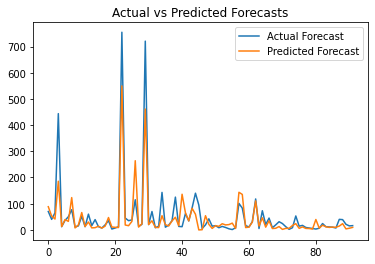

92
56
Week 21 - Error {'mae': 24.582404301542304, 'mape': 0.4736295697888779, 'uf_mape': 0.4736295697888779, 'buffer': 119.99364929783391}


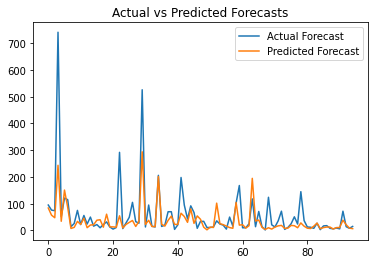

95
58
Week 22 - Error {'mae': 29.950284543790314, 'mape': 0.5296494846723901, 'uf_mape': 0.5296494846723901, 'buffer': 157.20331047861035}


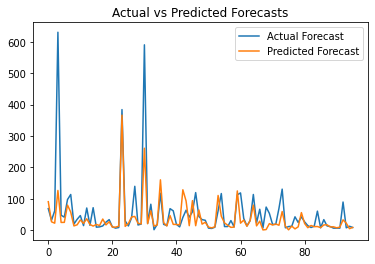

96
57
Week 23 - Error {'mae': 28.139303204913933, 'mape': 0.5151359854446487, 'uf_mape': 0.5151359854446487, 'buffer': 153.56413232464644}


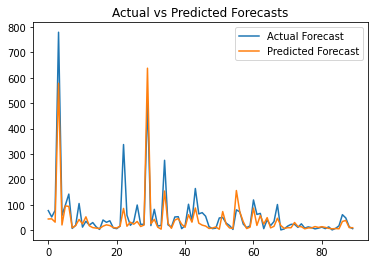

90
61
Week 24 - Error {'mae': 23.472390209303963, 'mape': 0.4236893539585553, 'uf_mape': 0.4236893539585553, 'buffer': 101.71469648184456}


In [118]:
model_21, pipeline_21, df_21 = run_model(model=XGBRegressor(), dataframe=df, target_week=21)
model_22, pipeline_22, df_22 = run_model(model=XGBRegressor(), dataframe=df, target_week=22)
model_23, pipeline_23, df_23 = run_model(model=XGBRegressor(), dataframe=df, target_week=23)
model_24, pipeline_24, df_24 = run_model(model=XGBRegressor(), dataframe=df, target_week=24)

In [119]:
df_all = pd.concat([df_21, df_22, df_23, df_24])
df_all[df_all['ItemCode'] == 3418]

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,WeeklySales,DiscountedAmount,ItemCode_Label,Last-3_Week_Sales,Last-3_Week_Diff,Last-4_Week_Sales,Last-4_Week_Diff,Last-5_Week_Sales,Last-5_Week_Diff,Last-3_Week_Promotion,PredictedSales
20,category_1,3418,w1,21,0,70,0.0,0,82.0,7.0,75.0,-7.0,82.0,2.0,0.0,88.344643
21,category_1,3418,w2,22,0,95,0.0,0,103.0,21.0,82.0,7.0,75.0,-7.0,0.0,83.792694
22,category_1,3418,w3,23,0,69,0.0,0,82.0,-21.0,103.0,21.0,82.0,7.0,0.0,91.060471
23,category_1,3418,w4,24,0,77,0.0,0,45.0,-37.0,82.0,-21.0,103.0,21.0,0.0,43.994392


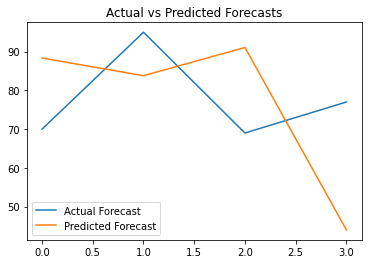

In [120]:
visualize_forecast(df_all[df_all['ItemCode'] == 3418]['WeeklySales'], df_all[df_all['ItemCode'] == 3418]['PredictedSales'])

In [123]:
buffer_values = {}
for item in df_all['ItemCode'].unique():
    df_item = df_all[df_all['ItemCode'] == item]
    buffer_value = calculate_buffer(df_item['WeeklySales'].values, df_item['PredictedSales'].values)
    buffer_values[item] = buffer_value
    

/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of emp

In [129]:
buffer_df = pd.DataFrame(buffer_values.items(), columns=['ItemCode', 'BufferValue'])

In [131]:
df_all_buffer = pd.merge(df_all, buffer_df, on = 'ItemCode', how = 'left')

In [134]:
df_all_buffer['BufferValue'] = df_all_buffer['BufferValue'].fillna(value = 0)

In [135]:
df_all_buffer

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,WeeklySales,DiscountedAmount,ItemCode_Label,Last-3_Week_Sales,Last-3_Week_Diff,Last-4_Week_Sales,Last-4_Week_Diff,Last-5_Week_Sales,Last-5_Week_Diff,Last-3_Week_Promotion,PredictedSales,BufferValue
0,category_1,3418,w1,21,0,70,0.0,0,82.0,7.0,75.0,-7.0,82.0,2.0,0.0,88.344643,36.906062
1,category_3,16936,w1,21,0,40,0.0,4,64.0,1.0,63.0,-22.0,85.0,47.0,0.0,52.651714,21.734157
2,category_1,17287,w1,21,1,65,7.0,5,57.0,31.0,26.0,6.0,20.0,-6.0,3.0,41.415504,52.507038
3,category_1,17296,w1,21,0,444,0.0,6,298.0,-610.0,908.0,241.0,667.0,107.0,0.0,185.714081,638.748483
4,category_4,23200,w1,21,1,12,32.0,8,0.0,0.0,0.0,0.0,0.0,-46.0,1.0,12.641362,34.053946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,category_2,1101571,w4,24,1,17,15.0,190,29.0,27.0,2.0,-8.0,10.0,5.0,2.0,5.398758,29.020017
369,category_3,1101661,w4,24,0,61,0.0,191,61.0,26.0,35.0,-6.0,41.0,-4.0,0.0,34.330086,63.241645
370,category_2,1101769,w4,24,0,48,0.0,192,35.0,11.0,24.0,-8.0,32.0,12.0,0.0,38.163925,20.271787
371,category_2,1105009,w4,24,0,13,0.0,194,9.0,-2.0,11.0,4.0,7.0,0.0,0.0,10.027378,11.813400


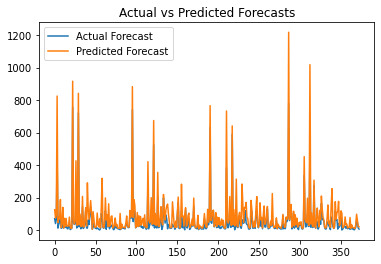

373
0


/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/envs/datastorm2/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value e

{'mae': 35.49502178967563,
 'mape': 0.6497346580727786,
 'uf_mape': nan,
 'buffer': nan}

In [136]:
calculate_results(df_all_buffer['WeeklySales'].values, df_all_buffer['PredictedSales'].values + df_all_buffer['BufferValue'].values)

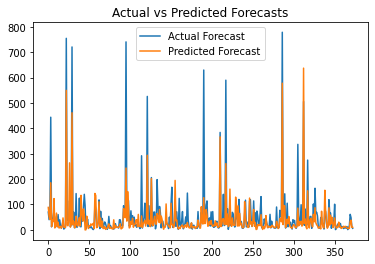

373
232


{'mae': 26.597175479654332,
 'mape': 0.4868600114791709,
 'uf_mape': 0.4868600114791709,
 'buffer': 135.78925917851646}

In [137]:
calculate_results(df_all_buffer['WeeklySales'].values, df_all_buffer['PredictedSales'].values)

In [139]:
test_21 = run_model(model = model_21, dataframe = None, target_week=21, pipeline= pipeline_21, mode = 'inference', train_dataframe=train_data, test_dataframe=test_df )
test_22 = run_model(model = model_22, dataframe = None, target_week=22, pipeline= pipeline_22, mode = 'inference', train_dataframe=train_data, test_dataframe=test_df )
test_23 = run_model(model = model_23, dataframe = None, target_week=23, pipeline= pipeline_23, mode = 'inference', train_dataframe=train_data, test_dataframe=test_df )
test_24 = run_model(model = model_24, dataframe = None, target_week=24, pipeline= pipeline_24, mode = 'inference', train_dataframe=train_data, test_dataframe=test_df )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CategoryCode           93 non-null     object 
 1   DiscountedAmount       93 non-null     float64
 2   ItemCode_Label         93 non-null     float64
 3   Last-3_Week_Diff       93 non-null     float64
 4   Last-3_Week_Promotion  93 non-null     float64
 5   Last-3_Week_Sales      93 non-null     float64
 6   Last-4_Week_Diff       93 non-null     float64
 7   Last-4_Week_Sales      93 non-null     float64
 8   Last-5_Week_Diff       93 non-null     float64
 9   Last-5_Week_Sales      93 non-null     float64
 10  OnPromotion            93 non-null     int64  
 11  PredictedSales         0 non-null      float64
 12  Week                   93 non-null     object 
 13  WeekID                 93 non-null     int64  
dtypes: float64(10), int64(2), object(2)
memory usage: 10.9+ KB
N

In [140]:
pd.DataFrame(test_24[0])

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,PredictedSales
282,category_3,893824,w4,24,0,41.808033
283,category_1,371239,w4,24,0,9.331027
284,category_1,35449,w4,24,0,13.846468
285,category_3,1081078,w4,24,0,11.140344
286,category_1,416212,w4,24,0,15.723699
...,...,...,...,...,...,...
372,category_1,145330,w4,24,0,14.521559
373,category_1,1032568,w4,24,0,10.495891
374,category_2,838456,w4,24,0,28.942650
375,category_4,1003192,w4,24,0,23.507656


In [141]:
submissions = test_data.drop(['PredictedSales'], axis = 1)
submissions

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,DiscountedAmount
0,category_2,32245,w1,21,0,0.0
1,category_1,1056463,w1,21,0,0.0
2,category_1,119554,w1,21,0,0.0
3,category_2,815101,w1,21,0,0.0
4,category_1,1054978,w1,21,0,0.0
...,...,...,...,...,...,...
372,category_1,145330,w4,24,0,0.0
373,category_1,1032568,w4,24,0,0.0
374,category_2,838456,w4,24,0,0.0
375,category_4,1003192,w4,24,0,0.0


In [142]:
all_concat = pd.concat([pd.DataFrame(test_21[0]), pd.DataFrame(test_22[0]), pd.DataFrame(test_23[0]), pd.DataFrame(test_24[0])])
all_concat

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,PredictedSales
0,category_2,32245,w1,21,0,42.938301
1,category_1,1056463,w1,21,0,78.213638
2,category_1,119554,w1,21,0,99.491684
3,category_2,815101,w1,21,0,25.992580
4,category_1,1054978,w1,21,0,51.425896
...,...,...,...,...,...,...
372,category_1,145330,w4,24,0,14.521559
373,category_1,1032568,w4,24,0,10.495891
374,category_2,838456,w4,24,0,28.942650
375,category_4,1003192,w4,24,0,23.507656


In [143]:
submissions1 = pd.merge(submissions,all_concat, on=["CategoryCode","ItemCode","Week","WeekID", "OnPromotion"], how = "left")
submissions1

,CategoryCode,ItemCode,Week,WeekID,OnPromotion,DiscountedAmount,PredictedSales
0,category_2,32245,w1,21,0,0.0,42.938301
1,category_1,1056463,w1,21,0,0.0,78.213638
2,category_1,119554,w1,21,0,0.0,99.491684
3,category_2,815101,w1,21,0,0.0,25.992580
4,category_1,1054978,w1,21,0,0.0,51.425896
...,...,...,...,...,...,...,...
372,category_1,145330,w4,24,0,0.0,14.521559
373,category_1,1032568,w4,24,0,0.0,10.495891
374,category_2,838456,w4,24,0,0.0,28.942650
375,category_4,1003192,w4,24,0,0.0,23.507656


In [144]:
submissions1.to_csv('submission_file.csv', index = False)

In [145]:
submissions2 = pd.merge(submissions1, buffer_df, on = 'ItemCode', how = 'left')

In [147]:
submissions2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CategoryCode      377 non-null    object 
 1   ItemCode          377 non-null    int64  
 2   Week              377 non-null    object 
 3   WeekID            377 non-null    int64  
 4   OnPromotion       377 non-null    int64  
 5   DiscountedAmount  377 non-null    float64
 6   PredictedSales    377 non-null    float32
 7   BufferValue       0 non-null      float64
dtypes: float32(1), float64(2), int64(3), object(2)
memory usage: 25.0+ KB
